In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2023-03-16 13:12:23.257547: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-16 13:12:24.245307: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/compat/lib.real:/opt/conda/lib/python3.8/site-packages/torch/lib:/opt/conda/lib/python3.8/site-packages/torch_tensorrt/lib:/usr/local/cuda/compat/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-16 13:12:24.245407: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.

In [3]:
image_size = (256, 256)
batch_size = 16

train_ds = tf.keras.utils.image_dataset_from_directory(
    "/workspace/Shantan_Data/Bayesian2v/Steel_Surface/data1/train30",
    validation_split=None,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 180 files belonging to 6 classes.


In [5]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    "/workspace/Shantan_Data/Bayesian2v/Steel_Surface/data1/val4",
    validation_split=None,
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 120 files belonging to 4 classes.


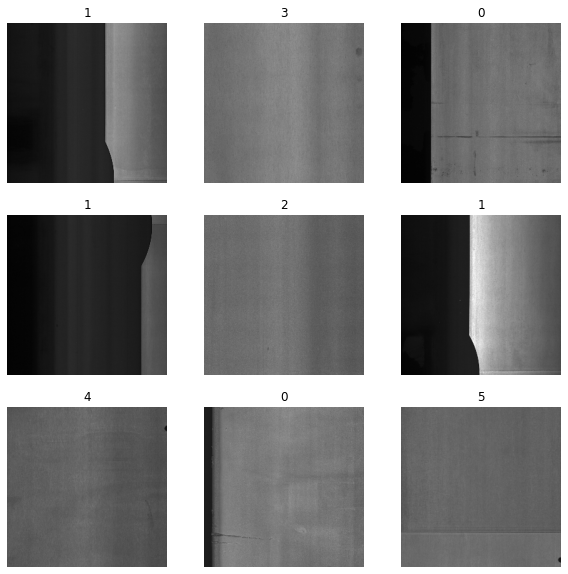

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")

In [7]:
pip install pydot

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [8]:
pip install graphviz

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Note: you may need to restart the kernel to use updated packages.


In [9]:
def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(256, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 10:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)


model = make_model(input_shape=image_size + (3,), num_classes=6)
keras.utils.plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [10]:
class_names = train_ds.class_names
print(class_names)

['crease1', 'crescent_gap1', 'inclusion1', 'oil_spot1', 'punching_hole1', 'welding_line1']


In [11]:
len(class_names)

6

In [12]:
from tensorflow.keras.models import Sequential

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(16, 256, 256, 3)
(16,)


In [14]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(100).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# num_classes = len(class_names)

# model = Sequential([
#   layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
#   layers.Conv2D(16, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(32, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Conv2D(64, 3, padding='same', activation='relu'),
#   layers.MaxPooling2D(),
#   layers.Flatten(),
#   layers.Dense(128, activation='relu'),
#   layers.Dense(num_classes)
# ])

In [23]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.keras"),
]
model.compile(
    optimizer=keras.optimizers.Adam(0.01),
    loss="SparseCategoricalCrossentropy",
    metrics=["accuracy"],
)
history=model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds,
)

Epoch 1/50
12/12 [==============================] - 8s 165ms/step - loss: 0.2783 - accuracy: 0.9167 - val_loss: 8.0103 - val_accuracy: 0.3333
Epoch 2/50
12/12 [==============================] - 2s 136ms/step - loss: 0.2732 - accuracy: 0.9167 - val_loss: 8.8748 - val_accuracy: 0.3250
Epoch 3/50
12/12 [==============================] - 2s 136ms/step - loss: 0.2493 - accuracy: 0.9056 - val_loss: 10.5382 - val_accuracy: 0.3583
Epoch 4/50
12/12 [==============================] - 2s 136ms/step - loss: 0.1742 - accuracy: 0.9500 - val_loss: 9.1518 - val_accuracy: 0.3250
Epoch 5/50
12/12 [==============================] - 2s 136ms/step - loss: 0.1751 - accuracy: 0.9556 - val_loss: 12.9033 - val_accuracy: 0.2833
Epoch 6/50
12/12 [==============================] - 3s 237ms/step - loss: 0.2151 - accuracy: 0.9333 - val_loss: 11.2331 - val_accuracy: 0.3750
Epoch 7/50
12/12 [==============================] - 2s 210ms/step - loss: 0.1663 - accuracy: 0.9389 - val_loss: 9.0039 - val_accuracy: 0.3667
Epo

In [17]:
import numpy as np

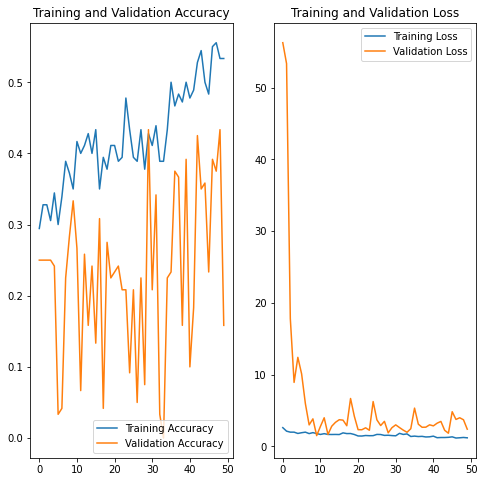

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
images,labels = val_ds
images

In [ ]:
model.predict